In [1]:
!pip install jiwer
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: rapidfuzz
    Found existing installation: rapidfuzz 3.1.1
    Uninstalling rapidfuzz-3.1.1:
      Successfully uninstalled rapidfuzz-3.1.1


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

2748572632/2748572632 [==============================] - 70s 0us/step


,file_name,normalized_transcription
0,LJ047-0187,It was then my plan to interview Marina Oswald...
1,LJ045-0213,"The conversation on Monday, November eighteen,..."
2,LJ019-0324,"The chaplain's duties were enlarged, and the p..."


In [4]:
!pip install keras
!pip install librosa
!pip install matplotlib

/tmp/ipykernel_28/2839158951.py:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


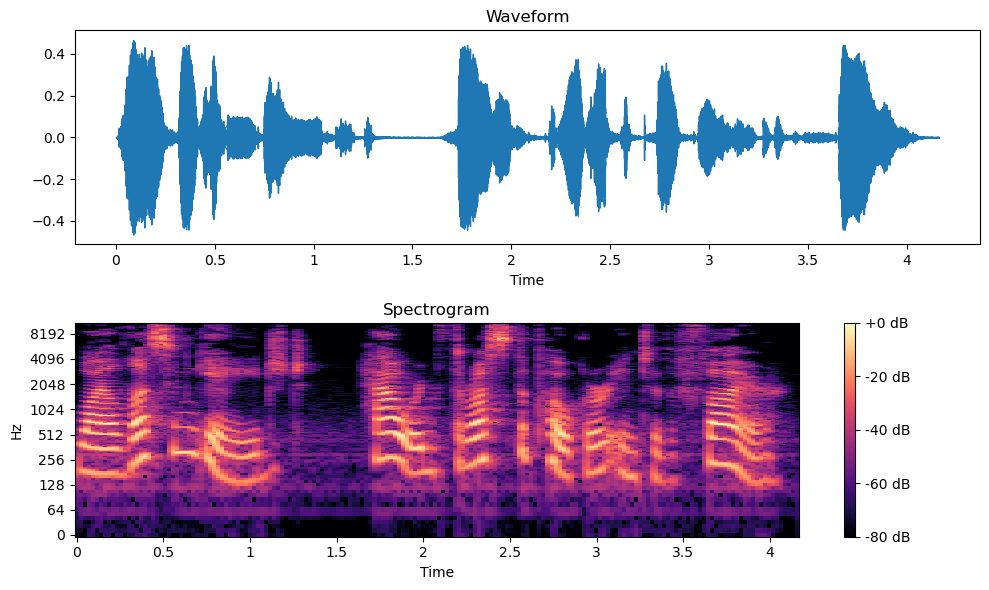

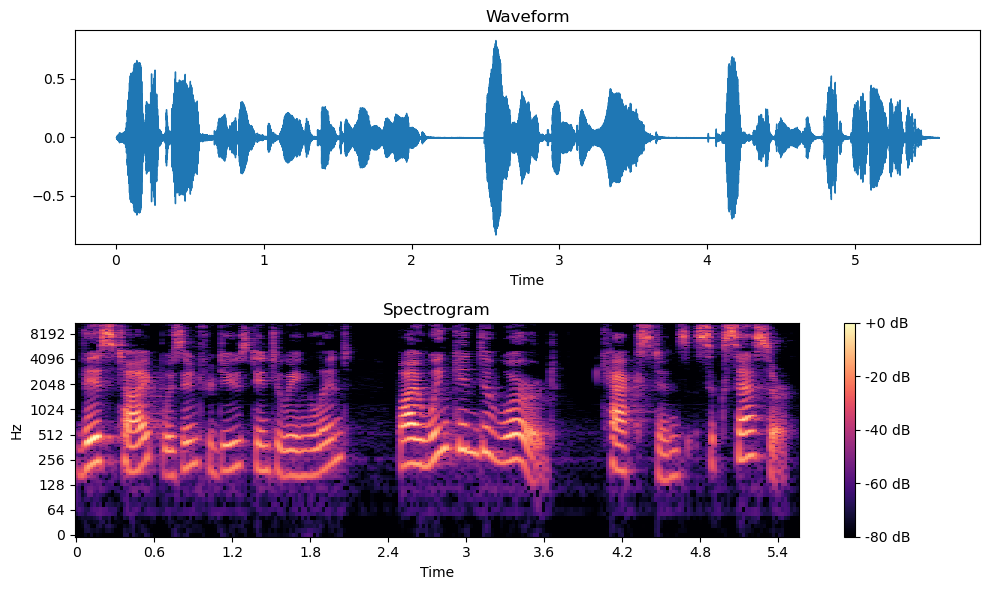

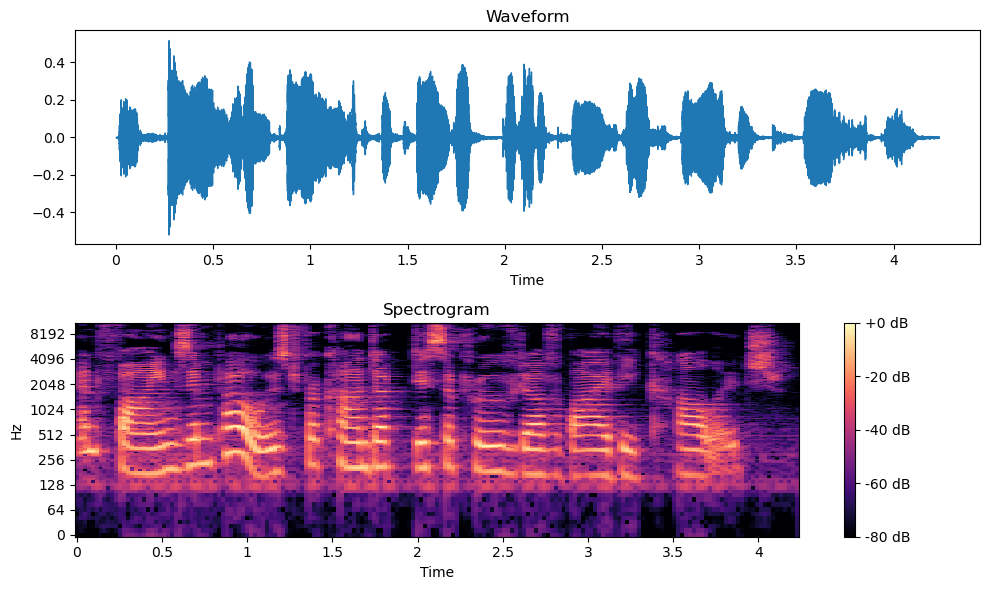

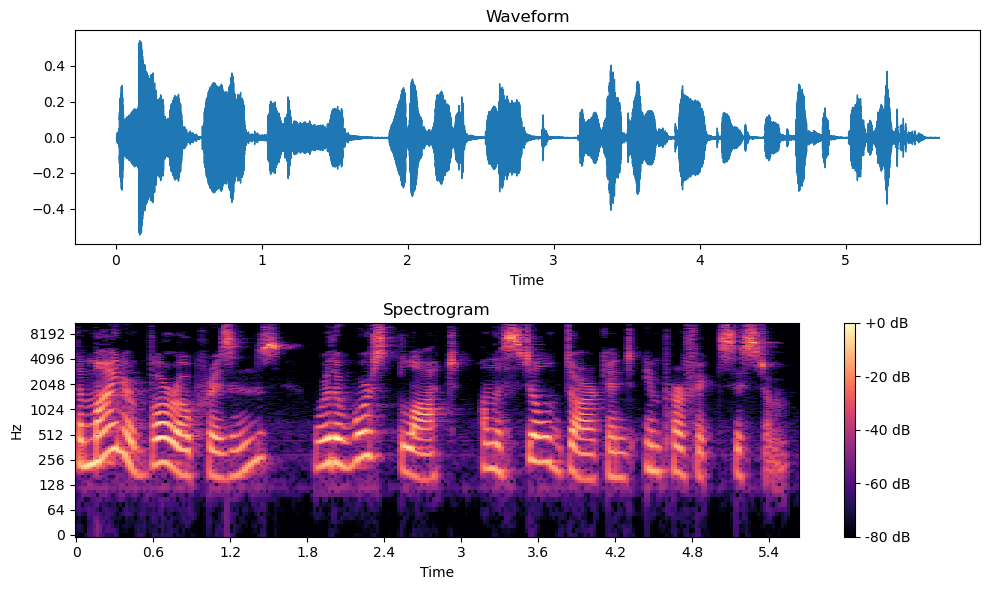

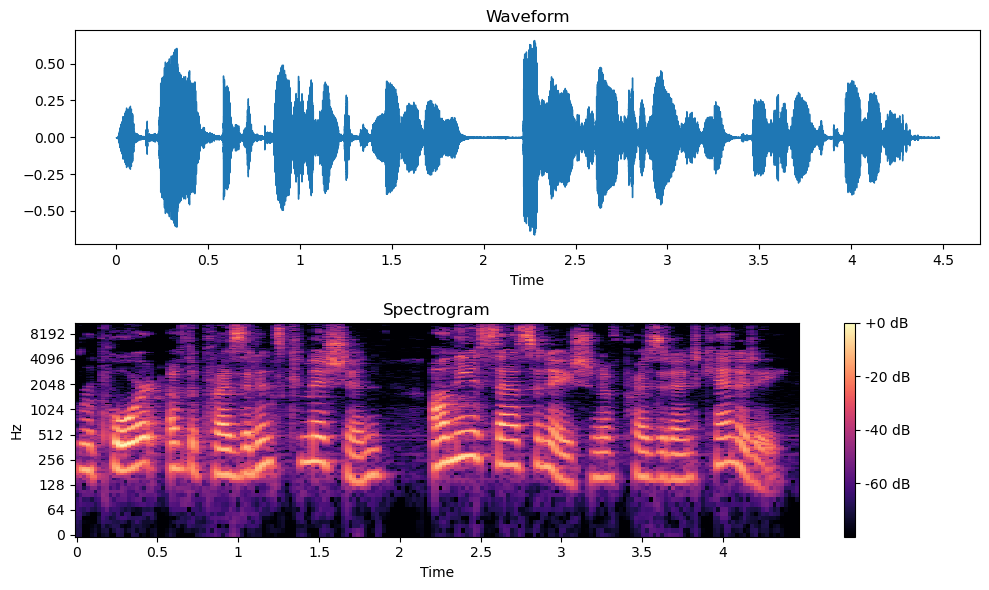

In [5]:
import os
import keras
import tarfile
import librosa
import librosa.display
import matplotlib.pyplot as plt

wav_files = [os.path.join(wavs_path, filename) for filename in os.listdir(wavs_path) if filename.endswith('.wav')]
def process_and_plot_wav(wav_file):
    y, sr = librosa.load(wav_file, sr=None)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    
    plt.tight_layout()
    plt.show()
for wav_file in wav_files[:5]:
    process_and_plot_wav(wav_file)

In [6]:
split = int(len(metadata_df) * 0.70)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 9170
Size of the training set: 3930


In [7]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [8]:
frame_length = 256
frame_step = 160
fft_length = 384


def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectrogram, label

In [9]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

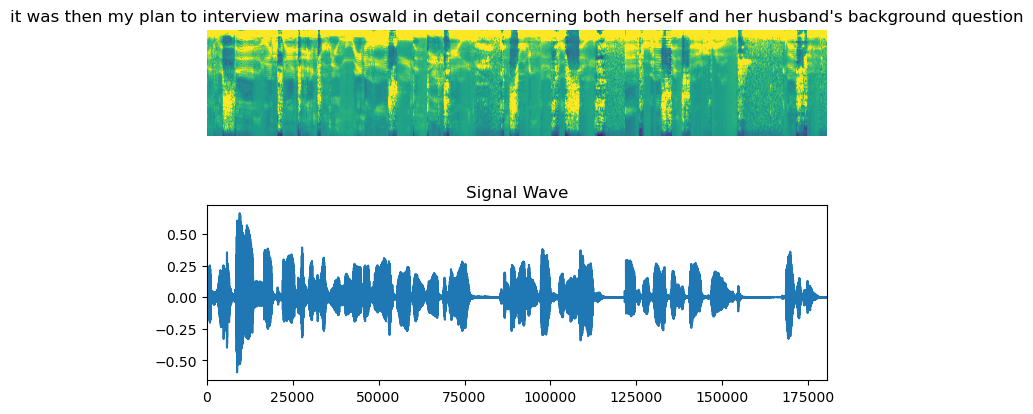

In [10]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [11]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [12]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output)
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                        128 

In [13]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [14]:
epochs = 30
validation_callback = CallbackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/30
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : he saw him empty the gun and throw the shells into some bushes on the southeast corner lot
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : without hesitation brought in a verdict of willful murder
Prediction: 
----------------------------------------------------------------------------------------------------
287/287 [==============================] - 1674s 6s/step - loss: 310.2698 - val_loss: 373.7096
Epoch 2/30
1/1 [==============================] - 0s 424ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9494
----------------------------

In [15]:
model.save("speech_to_text_model")

In [16]:
loaded_model = keras.models.load_model("speech_to_text_model", compile=False)

In [17]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 418ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2725
----------------------------------------------------------------------------------------------------
Target    : james c cadigan a questioneddocuments expert with the bureau compared the samples with the paper and tape in the actual bag
Prediction: james c cadigan a questioned documents expert with the bureau compared the samples with the paper and tape in the actual bag
----------------------------------------------------------------------------------------------------
Target    : which he believed was where the bag reached when it was laid on the seat with one edge against the door
Prediction: which he believed was where the bag reached when it was lade on the seat with one ege against the door
----------------------------------------------------------------------------------------------------
Target    : now

In [18]:
test_sample = next(iter(validation_dataset))
test_input, test_target = test_sample
test_prediction = loaded_model.predict(test_input)

1/1 [==============================] - 3s 3s/step


In [19]:
def decode_single_prediction(prediction):
    int_prediction = tf.argmax(prediction, axis=-1)
    predicted_text = tf.strings.reduce_join(num_to_char(int_prediction)).numpy().decode("utf-8")
    return predicted_text

decoded_prediction = decode_single_prediction(test_predicti on[0])
decoded_target = tf.strings.reduce_join(num_to_char(test_target[0])).numpy().decode("utf-8")

print("Original Target:", decoded_target)
print("Loaded Model Prediction:", decoded_prediction)
print("WER:", wer([decoded_target], [decoded_prediction]))

Original Target: in directing it i shall recognize six fundamental principles
Loaded Model Prediction: innddiireeccctiinnggg  iitt  iishaallll  rrreeccoogggnnizzee  ssiiixxxx  fuun  dimmennntaaalll pprrrinncciippllleess
WER: 1.0


In [20]:
import librosa
your_audio_file = '/kaggle/input/audio12/small.wav'
sr = 16000 
loaded_model = keras.models.load_model("speech_to_text_model", compile=False)
def preprocess_audio(audio_file):
    audio, _ = librosa.load(audio_file, sr=sr, mono=True)
    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    mean = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddev = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - mean) / (stddev + 1e-10)
    return spectrogram

your_audio_spectrogram = preprocess_audio(your_audio_file)
def decode_single_prediction(prediction):
    int_prediction = tf.argmax(prediction, axis=-1)
    predicted_text = tf.strings.reduce_join(num_to_char(int_prediction)).numpy().decode("utf-8")
    return predicted_text

your_audio_prediction = loaded_model.predict(tf.expand_dims(your_audio_spectrogram, axis=0))
decoded_prediction = decode_single_prediction(your_audio_prediction[0])

print("Your Audio Prediction:", decoded_prediction)

1/1 [==============================] - 5s 5s/step
Your Audio Prediction: thhiifi   itti  fiffiinn awwwwiieebbu  iit  a  thatt phammeei  petttee  a    thiiminng uuupt  ofllllieeaap  ouretiff aan a ggaaa   a  fiifhe  offf ath  hiff  ffrrik cukerr afiie i  ffi  iit iffii  a  feakkerr  ffaeeedddu  i a ffff  flliiffe  rrrekhherrhi ddakhe ffooui  rrayfhhrrre i  ffi itt ffhifher it  a   iihh lli aatt  addate  ifff  fo abe  rrre ll  ffi  att wwwhhhilllee i uuuuu i  faa houpp  wwhhi at ifaalllllff  the aatt  i aallll aalrreaa i  fff   fivitt  aa wwakkitthhdekkkaa aa ti  aotherrtthaitterr  a rreff annd  i  fiffffer  attt  ii  tthhaatttawwwhhannbeeh  aatt wwwinnkk uuttaaua  fifff  aaiiigggutt aao kkett  vvaat ii a  i  thhheyyh   a  ahhhe  thhek   ivee hhhealaa erri  ff fhaannkkrrraabrraakk iffi a   ttrrekk ifff  ouuuttt  annn effhhek  fekkhia  haatt ffulll hhau  a  hii offiff  rrofeiee    ifff  hhiie diff  baat  hha  braa a  ii  ffiii  ffffthhhiima faarree eerrr aa  o ffa    furri battaa aanmitth